In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, _ in os.walk('/kaggle/input'):
        print(dirname)

/kaggle/input
/kaggle/input/waste-classification-data
/kaggle/input/waste-classification-data/DATASET
/kaggle/input/waste-classification-data/DATASET/TEST
/kaggle/input/waste-classification-data/DATASET/TEST/R
/kaggle/input/waste-classification-data/DATASET/TEST/O
/kaggle/input/waste-classification-data/DATASET/TRAIN
/kaggle/input/waste-classification-data/DATASET/TRAIN/R
/kaggle/input/waste-classification-data/DATASET/TRAIN/O
/kaggle/input/waste-classification-data/dataset
/kaggle/input/waste-classification-data/dataset/DATASET
/kaggle/input/waste-classification-data/dataset/DATASET/TEST
/kaggle/input/waste-classification-data/dataset/DATASET/TEST/R
/kaggle/input/waste-classification-data/dataset/DATASET/TEST/O
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN/R
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN/O
/kaggle/input/input-samples


In [2]:
train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN/"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST/"

## Import Libraries

In [3]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from glob import glob

## Visualization

In [4]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 12565/12565 [01:29<00:00, 140.00it/s]


In [5]:
data.shape

(22564, 2)

In [6]:
from collections import Counter
Counter(y_data)

Counter({'R': 9999, 'O': 12565})

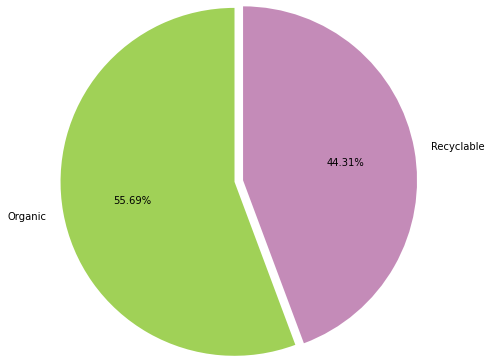

In [7]:
colors = ['#a0d157','#c48bb8']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

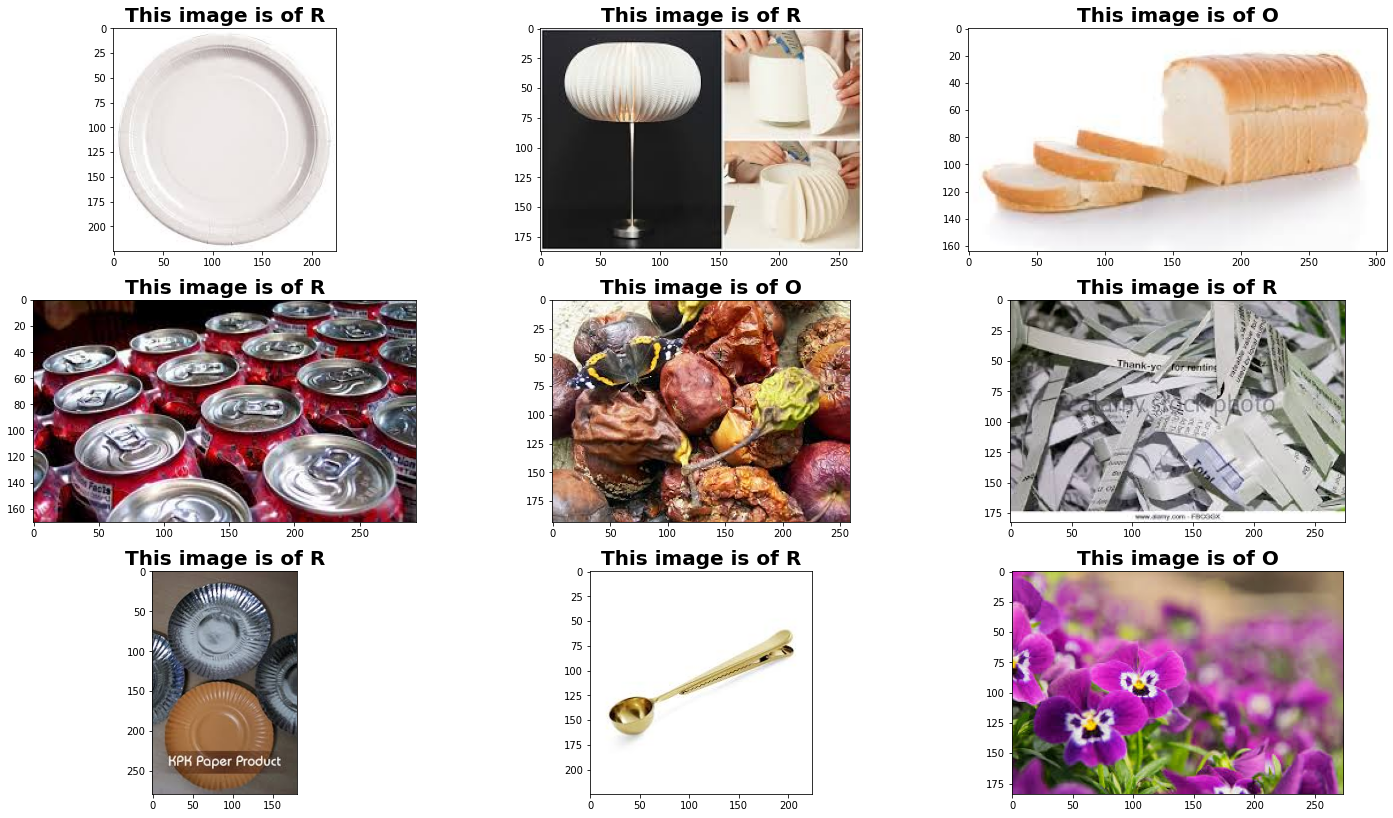

In [8]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

* O -> Organic
* R -> Recyclable

In [9]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


# Convolutional Neural Network - CNN

In [10]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

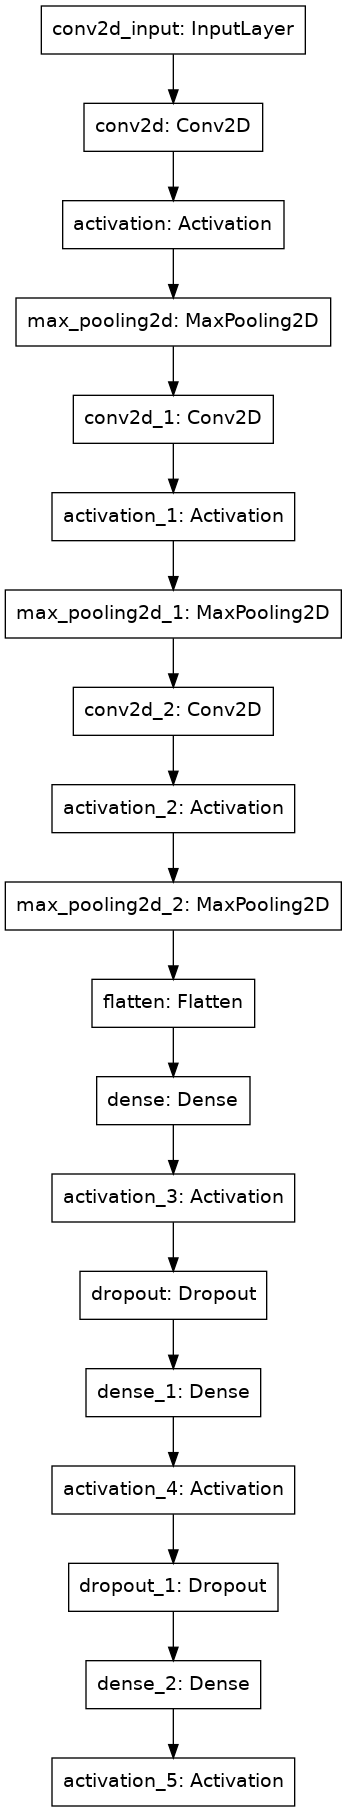

In [11]:
plot_model(model)

In [12]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [13]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [15]:
hist = model.fit_generator(
        generator = train_generator,
        epochs=2,
        validation_data = test_generator)

Epoch 1/2
89/89 [==============================] - 1235s 14s/step - loss: 0.5655 - accuracy: 0.7370 - val_loss: 0.3797 - val_accuracy: 0.8444
Epoch 2/2
89/89 [==============================] - 1214s 14s/step - loss: 0.4156 - accuracy: 0.8275 - val_loss: 0.2832 - val_accuracy: 0.8953


## Model Prediction

In [18]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

This image -> Organic


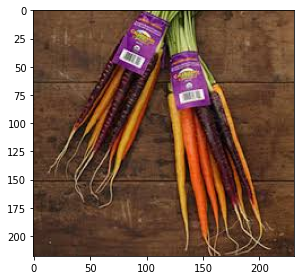

In [19]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12573.jpg")
predict_func(test_img)

This image -> Recyclable


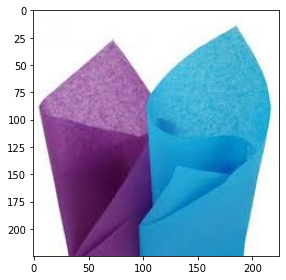

In [20]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10753.jpg")
predict_func(test_img)

In [21]:
accuracy = model.evaluate_generator(test_generator)
print("Accuracy:", accuracy)


Accuracy: [0.28319814801216125, 0.8953441977500916]


This image -> Organic


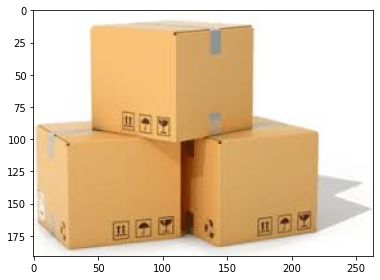

In [24]:
test_img = cv2.imread("/kaggle/input/input-samples/cardboard.jpeg")
predict_func(test_img)

This image -> Organic


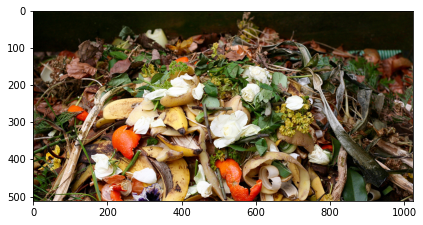

In [25]:
test_img = cv2.imread("/kaggle/input/input-samples/food-waste.jpg")
predict_func(test_img)

This image -> Recyclable


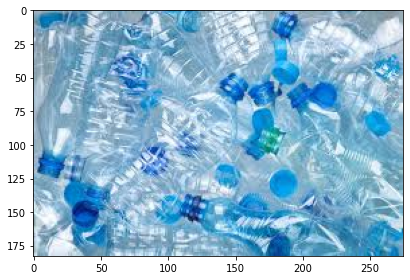

In [26]:
test_img = cv2.imread("/kaggle/input/input-samples/plastic.jpeg")
predict_func(test_img)

This image -> Organic


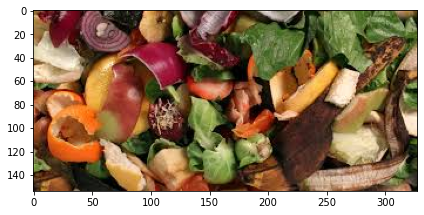

In [27]:
test_img = cv2.imread("/kaggle/input/input-samples/organic.jpeg")
predict_func(test_img)